# REFERENCE SOLUTION: PyTorch MNIST Lift and Shift Exercise

For this exercise notebook, use the `Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)` kernel on SageMaker Studio, or `conda_pytorch_p38` on classic SageMaker Notebook Instances.

---

## Introduction

Your new colleague in the data science team (who isn't very familiar with SageMaker) has written a nice notebook to tackle an image classification problem with PyTorch: [Local Notebook.ipynb](Local%20Notebook.ipynb).

It works OK with the simple MNIST data set they were working on before, but now they'd like to take advantage of some of the features of SageMaker to tackle bigger and harder challenges.

**Can you help refactor the Local Notebook code, to show them how to use SageMaker effectively?**


## Getting Started

First, check you can **run the [Local Notebook.ipynb](Local%20Notebook.ipynb) notebook through** - reviewing what steps it takes.

**This notebook** sets out a structure you can use to migrate code into, and lists out some of the changes you'll need to make at a high level. You can either work directly in here, or duplicate this notebook so you still have an unchanged copy of the original.

Try to work through the sections first with an MVP goal in mind (fitting the model to data in S3 via a SageMaker Training Job, and deploying/using the model through a SageMaker Endpoint). At the end, there are extension exercises to bring in more advanced functionality.


## Dependencies

Listing all our imports at the start helps to keep the requirements to run any script/file transparent up-front, and is specified by nearly every style guide including Python's official [PEP 8](https://www.python.org/dev/peps/pep-0008/#imports)


In [2]:
!pip install "ipycanvas<0.13" "ipywidgets<8" matplotlib

  Using cached ipycanvas-0.12.1-py2.py3-none-any.whl (257 kB)
  Using cached ipywidgets-7.8.1-py2.py3-none-any.whl (124 kB)
  Using cached widgetsnbextension-3.6.6-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyterlab_widgets-1.1.7-py3-none-any.whl (295 kB)
  Using cached comm-0.2.0-py3-none-any.whl (7.0 kB)
  Using cached notebook-7.0.6-py3-none-any.whl (4.0 MB)
  Using cached notebook_shim-0.2.3-py3-none-any.whl (13 kB)
  Using cached jupyterlab-4.0.9-py3-none-any.whl (9.2 MB)
  Using cached jupyter_server-2.11.0-py3-none-any.whl (379 kB)
  Using cached jupyterlab_server-2.25.2-py3-none-any.whl (58 kB)
  Using cached jupyter_events-0.9.0-py3-none-any.whl (18 kB)
  Using cached overrides-7.4.0-py3-none-any.whl (17 kB)
  Using cached anyio-4.0.0-py3-none-any.whl (83 kB)
  Using cached nbconvert-7.11.0-py3-none-any.whl (256 kB)
  Using cached jupyter_server_terminals-0.4.4-py3-none-any.whl (13 kB)
  Using cached Send2Trash-1.8.2-py3-none-any.whl (18 kB)
  Using cached websocket_client

In [3]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import glob
import os

# External Dependencies:
import matplotlib.pyplot as plt
import numpy as np

# Local Notebook Utils:
import util

# TODO: What else will you need?
# Have a look at the documentation: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html
# to see which libraries need to be imported to use sagemaker and the PyTorch estimator
from PIL import Image
import sagemaker
from IPython.display import HTML, display
from sagemaker.pytorch import PyTorch as PyTorchEstimator

## Prepare the Data

Let's download the image data from the Repository of Open Data on AWS and sample a subset like we did in the [Local Notebook.ipynb](Local%20Notebook.ipynb).

**Check you understand** what data it's going to upload from this notebook, and where it's going to store it in S3, then start the upload running while you work on the rest.

In [4]:
local_dir = "/tmp/mnist"
training_dir = f"{local_dir}/training"
testing_dir = f"{local_dir}/testing"

# Download the MNIST data from the Registry of Open Data on AWS
!rm -rf {local_dir}
!mkdir -p {local_dir}
!aws s3 cp s3://fast-ai-imageclas/mnist_png.tgz {local_dir} --no-sign-request

# Un-tar the MNIST data, stripping the leading path element; this will leave us with directories
# {local_dir}/testing/ and {local_dir/training/
!tar zxf {local_dir}/mnist_png.tgz -C {local_dir}/ --strip-components=1 --no-same-owner

# Get the list of files in tne training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# Reduce the data by keeping every Nth file and dropping the rest of the files.
reduction_factor = 2
train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# Delete all the files not to be kept
for fname in set(train_files) ^ set(train_files_to_keep):
    os.remove(fname)

for fname in set(test_files) ^ set(test_files_to_keep):
    os.remove(fname)

print("Done!")

download: s3://fast-ai-imageclas/mnist_png.tgz to ../../../../tmp/mnist/mnist_png.tgz
Training files: 60000
Testing files:  10000
Training files kept: 30000
Testing files kept:  5000
Done!


## Set Up Execution Role, Session and S3 Bucket

Now that we have downloaded and reduced the data in the local directory, we will need to upload it to Amazon S3 to make it available for Amazon Sagemaker training.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region.
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from SageMaker Python SDK.


In [5]:
# TODO: This is where you can setup execution role, session and S3 bucket.
# 1. Setup the SageMaker role
role = sagemaker.get_execution_role()
# 2. Setup the SageMaker session
sess = sagemaker.Session()
# 3. Setup the SageMaker default bucket
bucket_name = sess.default_bucket()  # We'll just use the default bucket as the other examples did

# Have a look at the previous examples to find out how to do it

## Upload Data to Amazon S3
Next is the part where you need to upload the images to Amazon S3 for Sagemaker training. You can refer to the previous example on how to do it using the [aws s3 sync](https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html) CLI command. The high-level command `aws s3 sync` command synchronizes the contents of the target bucket and source directory. It allows the use of options such as `--delete` that allows to remove objects from the target that are not present in the source and `--exclude` or `--include` options that filter files or objects to exclude or not exclude.

> ⏰ Note: Uploading to Amazon S3 typically takes about 2-3 minutes assuming a `reduction_factor` of 2.

In [6]:
# TODO: This is where you upload the training images using `aws s3 sync`.
# Fill in the missing source local directory and the target S3 bucket and folder in the command below.
!aws s3 sync --quiet --delete {local_dir} s3://{bucket_name}/mnist --exclude "*.tgz" && echo "Done!"

Done!


You can check your data is uploaded by finding your bucket in the [Amazon S3 Console](https://s3.console.aws.amazon.com/s3/home). Do you see the folders of images as expected?

## Data Input ("Channels") Configuration

The draft code has **2 data sets**: One for training, and one for test/validation. (For classification, the folder location of each image is sufficient as a label).

In SageMaker terminology, each input data set is a "channel" and we can name them however we like... Just make sure you're consistent about what you call each one!

For a simple input configuration, a channel spec might just be the S3 URI of the folder. For configuring more advanced options, there's the [s3_input](https://sagemaker.readthedocs.io/en/stable/inputs.html) class in the SageMaker SDK.


In [7]:
# TODO: Define your 2 data channels
# The data can be found in: "s3://{bucket_name}/mnist/train" and "s3://{bucket_name}/mnist/test"

# We can use either the s3_input (which gives us additional configuration options), or a plain string:
train_channel = sagemaker.inputs.TrainingInput(f"s3://{bucket_name}/mnist/training")
test_channel = f"s3://{bucket_name}/mnist/testing"

inputs = {"train": train_channel, "test": test_channel}
print(inputs)

{'train': <sagemaker.inputs.TrainingInput object at 0x7faf94cc0f70>, 'test': 's3://sagemaker-us-east-1-213450005126/mnist/testing'}


## Algorithm ("Estimator") Configuration and Run

Instead of loading and fitting this data here in the notebook, we'll be creating a [PyTorch Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-estimator) through the SageMaker SDK, to run the code on a separate container that can be scaled as required.

The ["Using PyTorch with the SageMaker Python SDK"](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) docs give a good overview of this process. You should run your estimator in **Python 3**.

**Use the [src/main.py](src/main.py) file** as your entry point to port code into - which has already been created for you with some basic hints.


In [8]:
# TODO: Create your PyTorch estimator

# Note the PyTorch class inherits from some cross-framework base classes with additional
# constructor options:
# https://sagemaker.readthedocs.io/en/stable/estimators.html
# https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#create-an-estimator

# We are using PyTorch 1.8 and python 3
# You can reuse the metrics definition from the previous example
# (Optional) Look at the Pytorch script and try to pass new hyperparameters

estimator = PyTorchEstimator(
    role=role,  # IAM role to run the job under - we just use the same as the notebook role
    ## Framework setup:
    entry_point="main.py",  # Target script
    source_dir="./src",  # Folder to bundle, in case we want to split the code between files
    framework_version="1.10",  # PyTorch version
    py_version="py38",  # Python version
    ## Infrastructure provisioning:
    instance_count=1,  # We haven't implemented parallelization in our script
    # instance_type="ml.p3.2xlarge",  # Keras should be accelerated by GPU though
    instance_type="ml.c5.2xlarge",  # Keras should be accelerated by GPU though
    max_run=30 * 60,  # The training shouldn't take too long to run
    use_spot_instances=True,  # May as well use spot to save money
    max_wait=40 * 60,  # ...And we don't want to wait for ages for spot instances
    ## Parameters to pass to our script:
    hyperparameters={
        "epochs": 12,
        "batch-size": 128,
    },
    ## Performance/progress metrics to scrape from console output:
    metric_definitions=[
        {"Name": "epoch", "Regex": "epoch: ([0-9\\.]+)"},
        {"Name": "train:loss", "Regex": "train_loss: ([0-9\\.]+)"},
        {"Name": "test:loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "test:accuracy", "Regex": "val_acc: ([0-9\\.]+)"},
    ],
    ## Let's keep our SageMaker records tidy by giving the training jobs a sensible name
    base_job_name="mnist-pytorch",
)

Before running the actual training on SageMaker TrainingJob, it can be good to run it locally first using the code below. If there is any error, you can fix them first before running using SageMaker TrainingJob.

In [9]:
!python3 src/main.py --train {training_dir} --test {testing_dir} --output-data-dir data/local-output --model-dir data/local-model --epochs=2 --batch-size=128

Loading label 0...1...2...3...4...5...6...7...8...9...Shuffling trainset...
Shuffling testset...
x_train shape: (30000, 1, 28, 28)
input_shape: (1, 28, 28)
30000 train samples
5000 test samples
n_labels: 10
y_train shape: (30000, 10)
model init
[2023-11-21 16:10:12.939 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:226 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-11-21 16:10:13.554 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:226 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
epoch: 1
train_loss: 0.000819
Evaluating model
val_loss: 0.0396
val_acc: 0.9258
epoch: 2
train_loss: 0.000327
Evaluating model
val_loss: 0.0202
val_acc: 0.9664


When you're ready to try your script in a Sagemaker training job, you can call `estimator.fit()` as we did in previous exercises:

In [10]:
# TODO: Call estimator.fit
estimator.fit(inputs)

# Note: As configured, this job took about 12 clock minutes (but only 3 billable minutes) to run,
# reaching a test accuracy of ~82%. The majority of the time is the download of images to the
# container - which could be significantly optimized as discussed later in the "Further
# Improvements" section

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: mnist-pytorch-2023-11-21-16-12-26-006


2023-11-21 16:12:26 Starting - Starting the training job...
2023-11-21 16:12:43 Starting - Preparing the instances for training.........
2023-11-21 16:14:17 Downloading - Downloading input data......
2023-11-21 16:15:13 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-11-21 16:15:20,192 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-11-21 16:15:20,193 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-21 16:15:20,200 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-11-21 16:15:20,202 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-11-21 16:15:20,398 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.tx

## Deploy and Use Your Model (Real-Time Inference)

If your training job has completed; and saved the model in the correct PyTorch model format; it should now be pretty simple to deploy the model to a real-time endpoint.

You can achieve this with the [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html).

In [11]:
# TODO: Deploy a real-time endpoint
predictor = estimator.deploy(
    # Low request volume, tiny model = tiny infrastructure is fine:
    initial_instance_count=1,
    instance_type="ml.t2.medium",
)

INFO:sagemaker:Creating model with name: mnist-pytorch-2023-11-21-16-19-15-048
INFO:sagemaker:Creating endpoint-config with name mnist-pytorch-2023-11-21-16-19-15-048
INFO:sagemaker:Creating endpoint with name mnist-pytorch-2023-11-21-16-19-15-048


--------------!

Reviewing the architecture from the example notebook, we set up the model to accept **batches** of **28x28** image tensors with **normalized 0-1 pixel values** and a **single color channel dimension**.

Assuming you haven't [added any custom inference pre-processing](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#serve-a-pytorch-model) to the script (for example to accept encoded JPEGs/PNGs, or arbitrary image shapes), we'll need to replicate that same format when we use our endpoint.

You can use the final "Explore Results" section of the local notebook as a guide. First, using the interactive widget:

In [12]:
# Create/reload the drawing widget:
widget = util.draw.PixelDrawCanvas(pen_size=4)
widget.display()

Request data shape (1, 1, 28, 28), type float32
Result confidences: [[0.09024136 0.1134364  0.09563513 0.10736959 0.09579602 0.10603072
  0.09638395 0.10174284 0.09619851 0.09716555]]


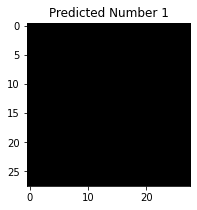

In [13]:
# Load the image from the widget:
img = widget.data.mean(-1) / 255  # (Convert full-RGB 0-255 to grayscale 0-1)

# TODO: Call your endpoint
input_data = np.expand_dims(img, [0, 1]).astype(np.float32)
print(f"Request data shape {input_data.shape}, type {input_data.dtype}")
result = predictor.predict(input_data)

print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(img, cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result)}")
plt.show()

Alternatively, to load and classify images from the test set:

Request data shape (1, 1, 28, 28), type float32
Result confidences: [[3.61463428e-08 4.85638338e-06 1.15449257e-06 1.09435161e-09
  9.99979615e-01 1.89576880e-07 7.06375900e-08 2.05969897e-07
  1.30838807e-05 6.54293217e-07]]


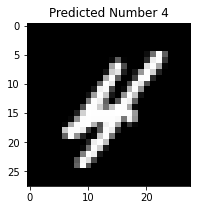

In [14]:
# TODO: Choose an image
label = "4"
filename = os.listdir(f"{testing_dir}/{label}")[0]

# TODO: Load the image.
# Note: Can feed numpy array to predictor. There is no need to build tensor.
# Load the image:
img = Image.open(f"{testing_dir}/{label}/{filename}")
input_data = np.squeeze(np.asarray(img)).astype(np.float32) / 255
input_data = np.expand_dims(np.expand_dims(input_data, 0), 0)
print(f"Request data shape {input_data.shape}, type {input_data.dtype}")

# Send to the model:
result = predictor.predict(input_data)
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(img, cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result)}")
plt.show()

## Further Improvements

If you've got the basic train/deploy/call cycle working, congratulations! This core pattern of experimenting in the notebook but executing jobs on scalable hardware is at the heart of the SageMaker data science workflow.

There are still plenty of ways we can use the tools better though: Read on for the next challenges!


### 1. Cut training costs easily with SageMaker Managed Spot Mode

AWS Spot Instances let you take advantage of unused capacity in the AWS cloud, at up to a 90% discount versus standard on-demand pricing! For small jobs like this, taking advantage of this discount is as easy as adding a couple of parameters to the Estimator constructor:

https://sagemaker.readthedocs.io/en/stable/estimators.html

Note that in general, spot capacity is offered at a discounted rate because it's interruptible based on instantaneous demand... Longer-running training jobs should implement checkpoint saving and loading, so that they can efficiently resume if interrupted part way through. More information can be found on the [Managed Spot Training in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html) page of the [SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/).


### 2. Parameterize your algorithm

Being able to change the parameters of your algorithm at run-time (without modifying the `main.py` script each time) is helpful for making your code more re-usable... But even more so because it's a pre-requisite for automatic hyperparameter tuning!

Job parameter parsing should ideally be factored into a separate function, and as a best practice should accept setting values through **both** command line flags (as demonstrated in the [official MXNet MNIST example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/mxnet_mnist/mnist.py)) **and** the [SageMaker Hyperparameter environment variable(s)](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-container-environmental-variables-user-scripts.html). Perhaps the official MXNet example could be improved by setting environment-variable-driven defaults to the algorithm hyperparameters, the same as it already does for channels?

Refactor your job to accept **epochs** and **batch size** as optional parameters, and show how you can set these before each training run through the [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html).


### 3. Tune your network hyperparameters

Re-use the same approach as before to parameterize some features in the structure of your network: Perhaps the sizes of the `Conv2D` kernels? The number, type, node count, or activation function of layers in the network? No need to stray too far away from the sample architecture!

Instead of manually (or programmatically) calling `estimator.fit()` with different hyperparameters each time, we can use SageMaker's Bayesian Hyperparameter Tuning functionality to explore the space more efficiently!

The SageMaker SDK Docs give a great [overview](https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning) of using the HyperparameterTuner, which you can refer to if you get stuck.

First, we'll need to define a specific **metric** to optimize for, which is really a specification of how to scrape metric values from the algorithm's console logs. 

Next, use the [\*Parameter](https://sagemaker.readthedocs.io/en/stable/tuner.html) classes (`ContinuousParameter`, `IntegerParameter` and `CategoricalParameter`) to define appropriate ranges for the hyperparameters whose combination you want to optimize.

With the original estimator, target metric and parameter ranges defined, you'll be able to create a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html) and use that to start a hyperparameter tuning job instead of a single model training job.

Pay attention to likely run time and resource consumption when selecting the maximum total number of training jobs and maximum parallel jobs of your hyperparameter tuning run... You can always view and cancel ongoing hyperparameter tuning jobs through the SageMaker Console.


### Additional Challenges

If you have time, the following challenges are trickier, and might stretch your SageMaker knowledge even further!

**Batch Transform / Additional Inference Formats**: As discussed in this notebook, the deployed endpoint expects a particular tensor data format for requests... This complicates the usually-simple task of re-purposing the same model for batch inference (since our data in S3 is in JPEG format). The SageMaker TensorFlow SDK docs provide guidance on accepting custom formats in the ["Create Python Scripts for Custom Input and Output Formats"](https://sagemaker.readthedocs.io/en/stable/using_tf.html#create-python-scripts-for-custom-input-and-output-formats) section. If you can refactor your algorithm to accept JPEG requests when deployed as a real-time endpoint, you'll be able to run it as a batch [Transformer](https://sagemaker.readthedocs.io/en/stable/transformer.html) against images in S3 with a simple `estimator.transformer()` call.

**Optimized Training Formats**: A dataset like this (containing many tiny objects) may take much less time to load in to the algorithm if we either converted it to the standard Numpy format that Keras distributes it in (just 4 files X_train, Y_train, X_test, Y_test); or *streaming* the data with [SageMaker Pipe Mode](https://aws.amazon.com/blogs/machine-learning/using-pipe-input-mode-for-amazon-sagemaker-algorithms/), instead of downloading it up-front.

**Experiment Tracking**: The [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) feature gives a more structured way to track trials across multiple related experiments (for example, different HPO runs, or between HPO and regular model training jobs). You can use the [official SageMaker Experiments Example](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-experiments) for guidance on how to track the experiments in this notebook... and should note that the [SageMaker Experiments SDK Docs](https://sagemaker-experiments.readthedocs.io/en/latest/) are maintained separately, since it's a different Python module.


## Clean-Up

Remember to clean up any persistent resources that aren't needed anymore to save costs: The most significant of these are real-time prediction endpoints, and this SageMaker Notebook Instance.

The SageMaker SDK [Predictor](https://sagemaker.readthedocs.io/en/stable/predictors.html) class provides an interface to clean up real-time prediction endpoints; and SageMaker Notebook Instances can be stopped through the SageMaker Console when you're finished.

You might also like to clean up any S3 buckets / content we created, to prevent ongoing storage costs.


In [ ]:
# TODO: Clean up any endpoints/etc to release resources
predictor.delete_endpoint(delete_endpoint_config=True)